In [24]:
# default_exp feature_importance

In [25]:
# export

import pandas as pd
import numpy as np
import logging

from mlbt.utils import PurgedKFold
from sklearn.metrics import log_loss, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

def feat_importance(
    events,
    X,
    y,
    n_estimators=200,#1000
    cv=10,
    max_samples=1.0,
    pct_embargo=0,
    scoring="accuracy",
    method="MDI",
    min_w_leaf=0.0,
    n_jobs=None,
    **kwargs
):
    logging.info(f"feat_importance for {len(X.columns)} features")
    # 1) prepare classifier, cv. max_features=1 to prevent masking
    # feature importance from a random forest
    clf = DecisionTreeClassifier(
        criterion="entropy",
        max_features=1,
        class_weight="balanced",
        min_weight_fraction_leaf=min_w_leaf,
    )

    clf = BaggingClassifier(
        base_estimator=clf,
        n_estimators=n_estimators,
        max_features=1.0,
        max_samples=max_samples,
        oob_score=True,
        n_jobs=n_jobs,
    )

    if method == "MDI":
        fit = clf.fit(X=X, y=y)
        imp = feat_imp_MDI(fit, feat_names=X.columns)
    elif method == "MDA":
        sample_weight = pd.Series(1, index=events.index)
        imp = feat_imp_MDA(
            clf=clf,
            X=X,
            y=y,
            cv=cv,
            t1=events["t1"],
            pct_embargo=pct_embargo,
            scoring=scoring,
        )

    imp = imp.sort_values("mean", ascending=True)

    return imp


def feat_imp_MDI(fit, feat_names):
    # feat importance based on IS mean impurity reduction
    df0 = {i: tree.feature_importances_ for i, tree in enumerate(fit.estimators_)}
    df0 = pd.DataFrame.from_dict(df0, orient="index")
    df0.columns = feat_names
    df0 = df0.replace(0, np.nan)  # because max_features = 1
    imp = pd.concat(
        {"mean": df0.mean(), "std": df0.std() * df0.shape[0] ** -0.5}, axis=1
    )
    imp /= imp["mean"].sum()
    return imp


def feat_imp_MDA(clf, X, y, cv, t1, pct_embargo, scoring="neg_log_loss"):
    # feat importance based on OOS score reduction
    if scoring not in ["neg_log_loss", "accuracy"]:
        raise ValueError("wrong scoring method")
    from sklearn.metrics import log_loss, accuracy_score
    logging.debug(f"MDA with {cv}-fold CV")

    cv_gen = PurgedKFold(n_splits=cv, t1=t1, pct_embargo=pct_embargo)
    scr0, scr1 = pd.Series(), pd.DataFrame(columns=X.columns)
    for i, (train, test) in enumerate(cv_gen.split(X=X)):
        logging.debug(f"MDA with {cv}-fold CV: fold {i+1}/{cv}")
        X0, y0 = X.iloc[train, :], y.iloc[train]
        X1, y1 = X.iloc[test, :], y.iloc[test]
        fit = clf.fit(X=X0, y=y0)
        if scoring == "neg_log_loss":
            prob = fit.predict_proba(X1)
            scr0.loc[i] = -log_loss(
                y1, prob, labels=clf.classes_
            )
        else:
            pred = fit.predict(X1)
            scr0.loc[i] = accuracy_score(y1, pred)

        for j in X.columns:
            X1_ = X1.copy(deep=True)
            np.random.shuffle(X1_[j].values)  # permutation of a single column
            if scoring == "neg_log_loss":
                prob = fit.predict_proba(X1_)
                scr1.loc[i, j] = -log_loss(
                    y1, prob, labels=clf.classes_
                )
            else:
                pred = fit.predict(X1_)
                scr1.loc[i, j] = accuracy_score(y1, pred)

    imp = (-scr1).add(scr0, axis=0)
    if scoring == "neg_log_loss":
        imp = imp / -scr1
    else:
        imp = imp / (1.0 - scr1)

    imp = pd.concat(
        {"mean": imp.mean(), "std": imp.std() * imp.shape[0] ** -0.5}, axis=1
    )
    return imp

In [26]:
import pandas as pd

In [27]:

from mlbt.load_data import DATA_DIR

In [28]:
x = DATA_DIR / 'dollar' / '@TU#C_fimp_fixed_horizon_50_none_[]_0.5-10-25-250-50-500-60-Num Ticks-VIX.XO-amihud-auto-close-column-com-d-ffd-kyle-lag_change-log_ret-roll-rollimp-size-symbol-time_bars-volratio_MDA.h5'
x = DATA_DIR / 'dollar' / '@TU#C_fimp_fixed_horizon_50_none_[]_amihud-auto-close-ffd-kyle-log-roll-rollimp-stdev-volratio_MDA.h5'



In [29]:
fimp = pd.read_hdf(x, 'table')

In [30]:
import seaborn

In [31]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn
import matplotlib.pyplot as mpl

%matplotlib inline
mpl.style.use('ggplot')
mpl.rcParams['figure.figsize'] = 16,45


In [32]:
# seaborn.barplot(y=fimp.index, x=fimp['mean'])

In [33]:
import pandas as pd
from mlbt.load_data import DATA_DIR

import os
def latest_files(files):
    return list(sorted(files, key=os.path.getmtime)[::-1])


files = latest_files([x for x in (DATA_DIR / 'dollar').files('*fimp*') if '_50_' in x and 'EDVIamdenenewffkokylolzmamepererorororosasisisytityvo_MDA' in x])
print(len(files))
imps = [pd.read_hdf(x, 'table') for x in files]


dfs = imps
mean = pd.concat([x["mean"] for x in dfs], axis=1).mean(axis=1)
std = pd.concat([x["std"] for x in dfs], axis=1).std(axis=1) * len(dfs) ** -0.5

res= pd.DataFrame({"mean": mean, "std": std})

47


/Users/doda/anaconda3/envs/metal/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app
/Users/doda/anaconda3/envs/metal/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


In [34]:
import json
filter = 'entropy'
filter = ''
key = 'konto_len'
key = 'name'
key = lambda x: f"{x.get('name')}{x.get('symbol')}"
# key = lambda x: f"{x.get('window')}{x.get('com')}"
# key = lambda x: f"{x.get('symbol')}"
# key = lambda x: f"{x}"
grouped_imp = pd.DataFrame(columns=['mean', 'std'])
# selected = res[res.index.str.contains('stdev')]
selected = res[[not filter or json.loads(x).get('name') == filter for x in res.index]]
jsons = [json.loads(x) for x in selected.index]
for k, gg in selected.groupby([key(x) for x in jsons]):
    print(k, gg['mean'].mean())
    grouped_imp.loc[k, 'mean'] = gg['mean'].mean()
    grouped_imp.loc[k, 'std'] = gg['std'].std() * gg.shape[0] ** -0.5


amihudNone 0.0009604446338670835
entropy{"name": "log_ret"} 0.000906455790695728
ewm_mean{"name": "sadf", "symbol": "{\"name\": \"make_bars\", \"resolution\": \"D\", \"size\": 1, \"symbol\": \"@ES#C\", \"type_\": \"time\"}"} 0.0001968479785744564
ewm_mean{"name": "volratio"} 0.0008061672236936876
ffdNone 0.0043835379059110275
kyleNone -0.0006945508288688854
lag{"name": "ewm_mean", "symbol": "{\"name\": \"volratio\"}", "window": 250} 0.0007126021647918833
lag{"name": "ewm_mean", "symbol": "{\"name\": \"volratio\"}", "window": 25} -0.0002909081012724066
lag{"name": "ewm_mean", "symbol": "{\"name\": \"volratio\"}", "window": 50} 0.0002044896087824456
lag{"name": "sadf", "symbol": "{\"name\": \"make_bars\", \"resolution\": \"D\", \"size\": 1, \"symbol\": \"@ES#C\", \"type_\": \"time\"}"} 0.0006477811591795375
log_retNone 0.0004133976842689997
rollNone 1.9644929322990375e-05
rollimpNone 0.00015688700884900123
rolling_max{"name": "sadf", "symbol": "{\"name\": \"make_bars\", \"resolution\": \

In [35]:
grouped_imp

,mean,std
amihudNone,0.000960445,8.24705e-05
"entropy{""name"": ""log_ret""}",0.000906456,5.05489e-05
"ewm_mean{""name"": ""sadf"", ""symbol"": ""{\""name\"": \""make_bars\"", \""resolution\"": \""D\"", \""size\"": 1, \""symbol\"": \""@ES#C\"", \""type_\"": \""time\""}""}",0.000196848,0.000116201
"ewm_mean{""name"": ""volratio""}",0.000806167,1.06412e-05
ffdNone,0.00438354,NaN
kyleNone,-0.000694551,2.5774e-05
"lag{""name"": ""ewm_mean"", ""symbol"": ""{\""name\"": \""volratio\""}"", ""window"": 250}",0.000712602,NaN
"lag{""name"": ""ewm_mean"", ""symbol"": ""{\""name\"": \""volratio\""}"", ""window"": 25}",-0.000290908,NaN
"lag{""name"": ""ewm_mean"", ""symbol"": ""{\""name\"": \""volratio\""}"", ""window"": 50}",0.00020449,NaN
"lag{""name"": ""sadf"", ""symbol"": ""{\""name\"": \""make_bars\"", \""resolution\"": \""D\"", \""size\"": 1, \""symbol\"": \""@ES#C\"", \""type_\"": \""time\""}""}",0.000647781,7.4862e-05


Text(0.5, 1.0, 'filter:, key:<function <lambda> at 0x1a26d492f0>')

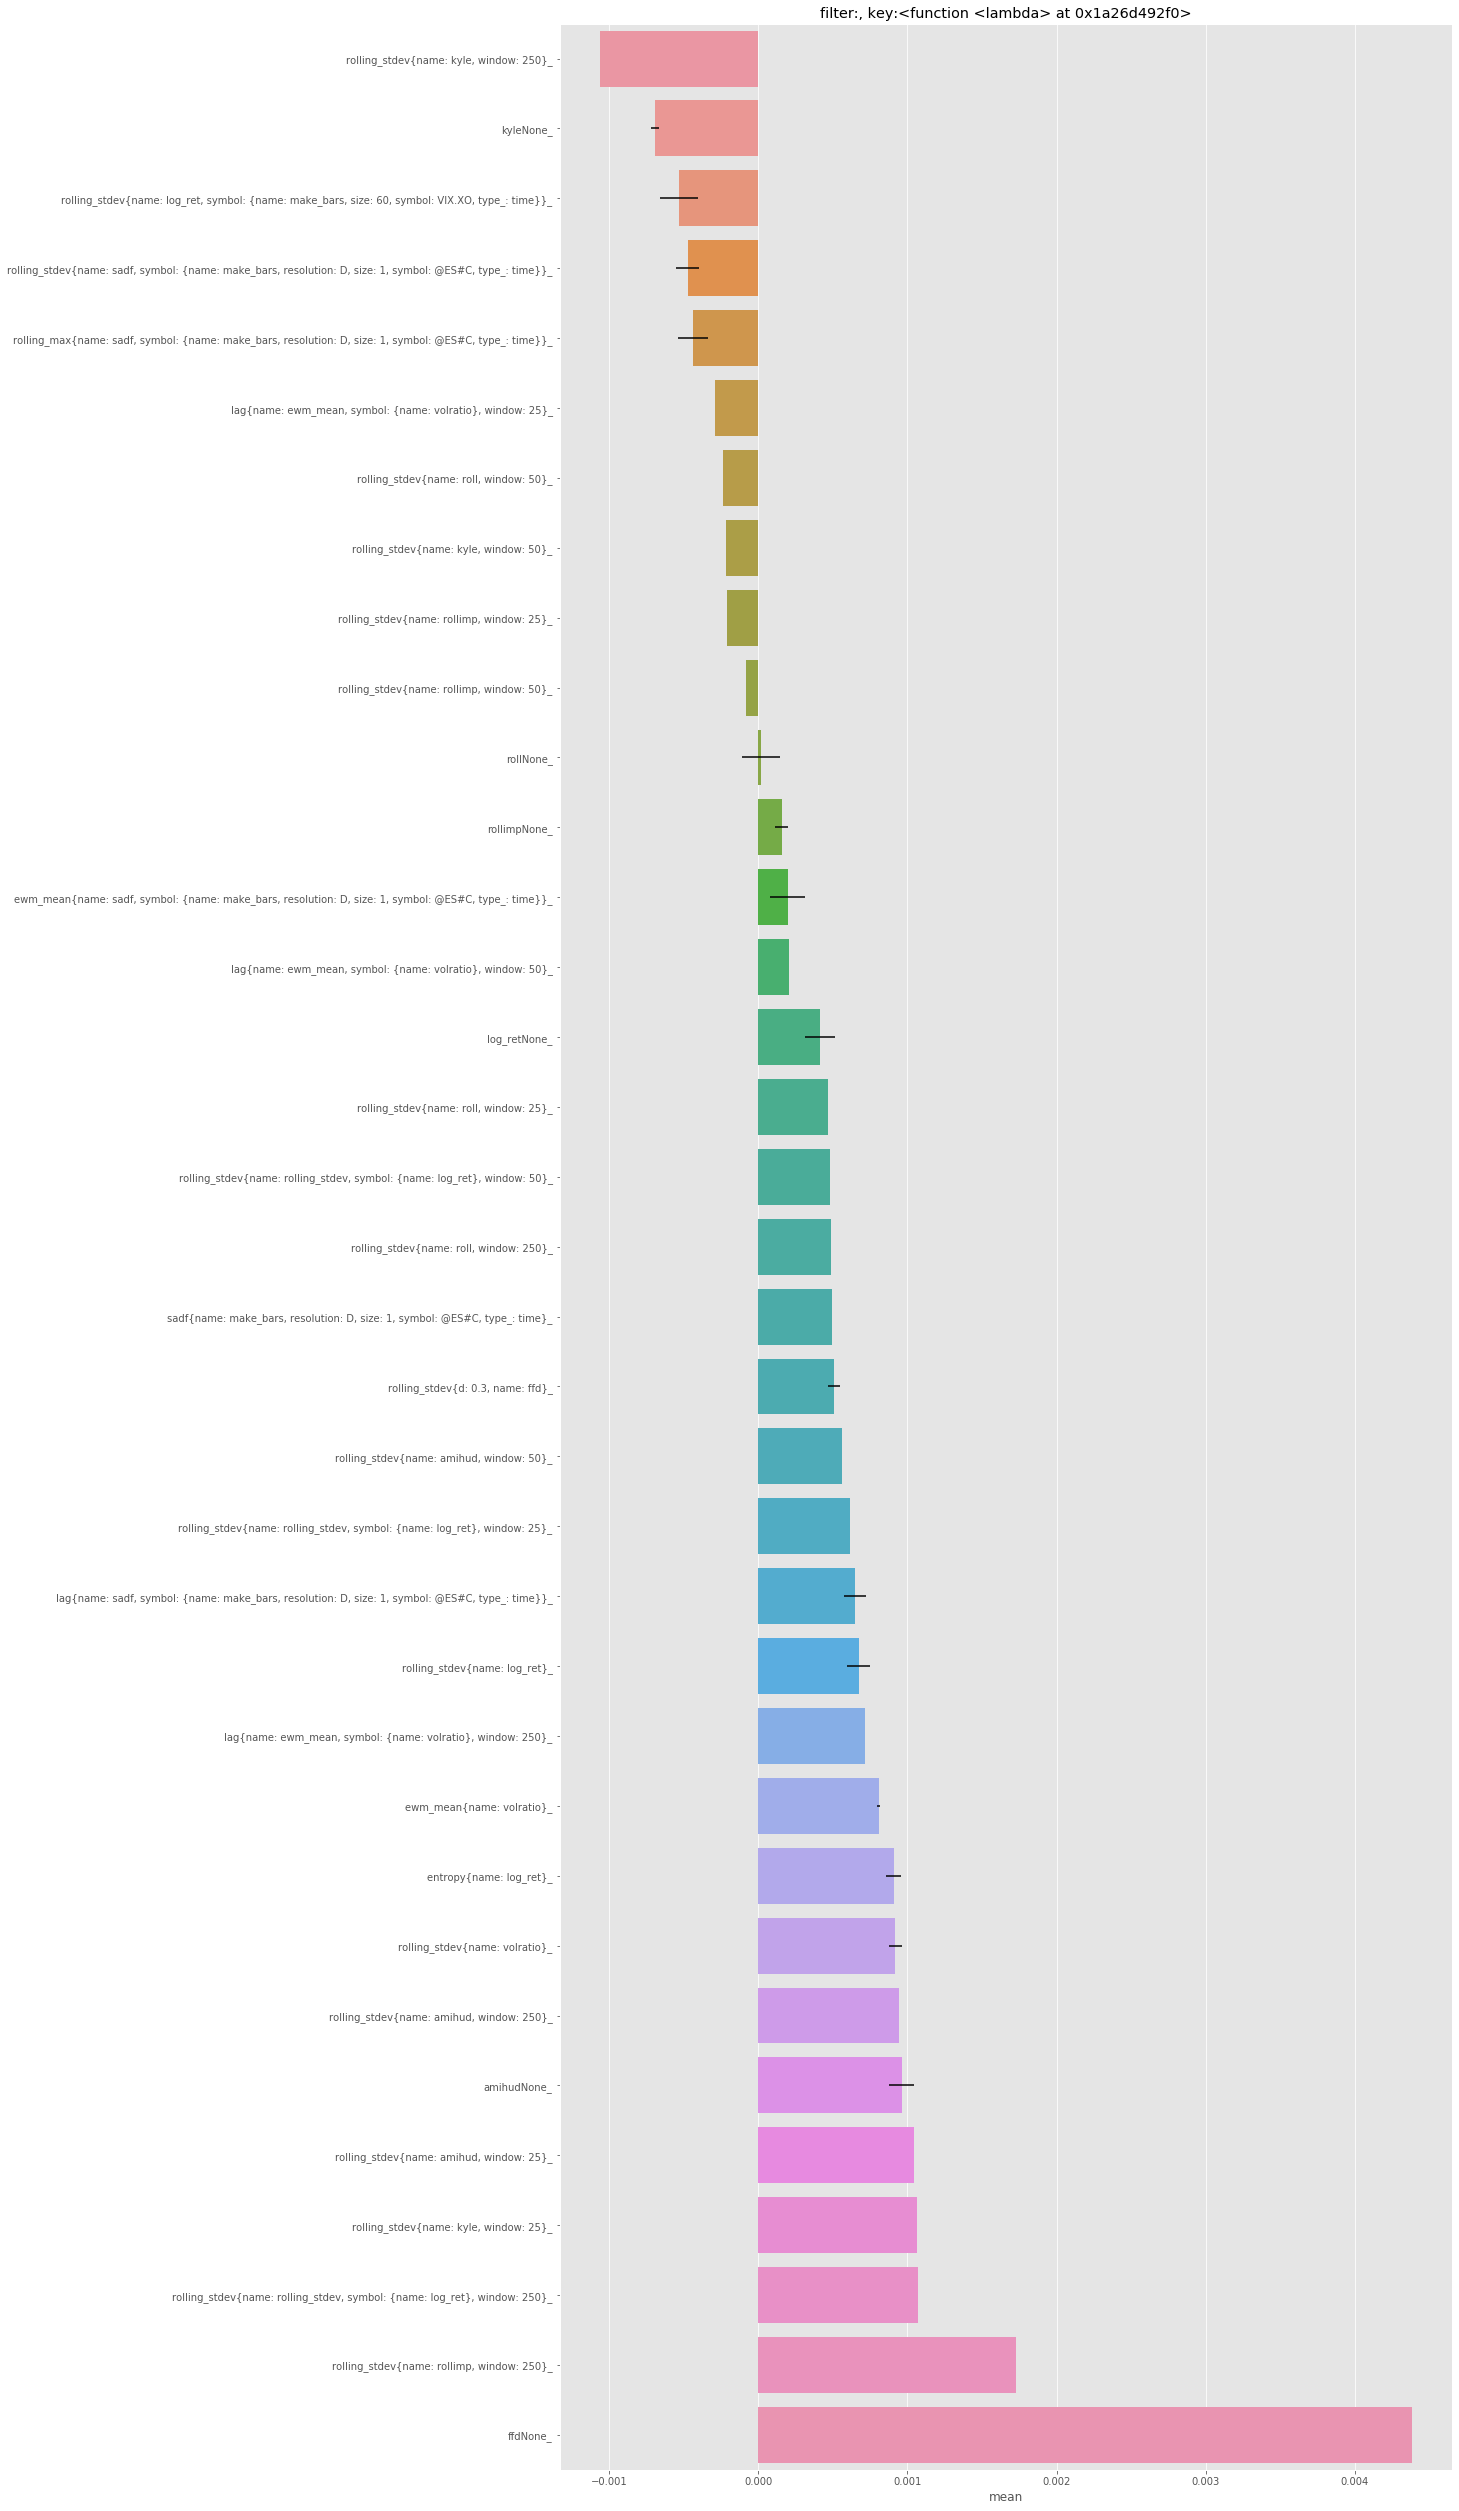

In [36]:
res2 = grouped_imp
res2 = res2.sort_values('mean')
seaborn.barplot(y=[str(x).replace('\\','').replace('"', '') + '_' for x in res2.index.values], x=res2['mean'], xerr=res2['std']).set_title(f"filter:{filter}, key:{key}")

array([False, False, False, False, False,  True,  True,  True, False,
       False,  True,  True, False,  True, False, False, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True, False, False, False,  True])

In [50]:
res.loc[res.index.str.contains('sadf')]

,mean,std
"{""lag"": 10, ""name"": ""lag"", ""symbol"": ""{\""name\"": \""sadf\"", \""symbol\"": \""{\\\""name\\\"": \\\""make_bars\\\"", \\\""resolution\\\"": \\\""D\\\"", \\\""size\\\"": 1, \\\""symbol\\\"": \\\""@ES#C\\\"", \\\""type_\\\"": \\\""time\\\""}\""}""}",0.000937,0.000411
"{""lag"": 100, ""name"": ""lag"", ""symbol"": ""{\""name\"": \""sadf\"", \""symbol\"": \""{\\\""name\\\"": \\\""make_bars\\\"", \\\""resolution\\\"": \\\""D\\\"", \\\""size\\\"": 1, \\\""symbol\\\"": \\\""@ES#C\\\"", \\\""type_\\\"": \\\""time\\\""}\""}""}",0.000136,0.000653
"{""lag"": 20, ""name"": ""lag"", ""symbol"": ""{\""name\"": \""sadf\"", \""symbol\"": \""{\\\""name\\\"": \\\""make_bars\\\"", \\\""resolution\\\"": \\\""D\\\"", \\\""size\\\"": 1, \\\""symbol\\\"": \\\""@ES#C\\\"", \\\""type_\\\"": \\\""time\\\""}\""}""}",0.000681,0.000746
"{""lag"": 250, ""name"": ""lag"", ""symbol"": ""{\""name\"": \""sadf\"", \""symbol\"": \""{\\\""name\\\"": \\\""make_bars\\\"", \\\""resolution\\\"": \\\""D\\\"", \\\""size\\\"": 1, \\\""symbol\\\"": \\\""@ES#C\\\"", \\\""type_\\\"": \\\""time\\\""}\""}""}",0.000437,0.000600
"{""lag"": 5, ""name"": ""lag"", ""symbol"": ""{\""name\"": \""sadf\"", \""symbol\"": \""{\\\""name\\\"": \\\""make_bars\\\"", \\\""resolution\\\"": \\\""D\\\"", \\\""size\\\"": 1, \\\""symbol\\\"": \\\""@ES#C\\\"", \\\""type_\\\"": \\\""time\\\""}\""}""}",0.000447,0.000385
"{""lag"": 50, ""name"": ""lag"", ""symbol"": ""{\""name\"": \""sadf\"", \""symbol\"": \""{\\\""name\\\"": \\\""make_bars\\\"", \\\""resolution\\\"": \\\""D\\\"", \\\""size\\\"": 1, \\\""symbol\\\"": \\\""@ES#C\\\"", \\\""type_\\\"": \\\""time\\\""}\""}""}",0.001248,0.000268
"{""name"": ""ewm_mean"", ""symbol"": ""{\""name\"": \""sadf\"", \""symbol\"": \""{\\\""name\\\"": \\\""make_bars\\\"", \\\""resolution\\\"": \\\""D\\\"", \\\""size\\\"": 1, \\\""symbol\\\"": \\\""@ES#C\\\"", \\\""type_\\\"": \\\""time\\\""}\""}"", ""window"": 100}",0.000464,0.000459
"{""name"": ""ewm_mean"", ""symbol"": ""{\""name\"": \""sadf\"", \""symbol\"": \""{\\\""name\\\"": \\\""make_bars\\\"", \\\""resolution\\\"": \\\""D\\\"", \\\""size\\\"": 1, \\\""symbol\\\"": \\\""@ES#C\\\"", \\\""type_\\\"": \\\""time\\\""}\""}"", ""window"": 10}",0.000766,0.000492
"{""name"": ""ewm_mean"", ""symbol"": ""{\""name\"": \""sadf\"", \""symbol\"": \""{\\\""name\\\"": \\\""make_bars\\\"", \\\""resolution\\\"": \\\""D\\\"", \\\""size\\\"": 1, \\\""symbol\\\"": \\\""@ES#C\\\"", \\\""type_\\\"": \\\""time\\\""}\""}"", ""window"": 20}",0.000599,0.000713
"{""name"": ""ewm_mean"", ""symbol"": ""{\""name\"": \""sadf\"", \""symbol\"": \""{\\\""name\\\"": \\\""make_bars\\\"", \\\""resolution\\\"": \\\""D\\\"", \\\""size\\\"": 1, \\\""symbol\\\"": \\\""@ES#C\\\"", \\\""type_\\\"": \\\""time\\\""}\""}"", ""window"": 250}",0.000813,0.000478


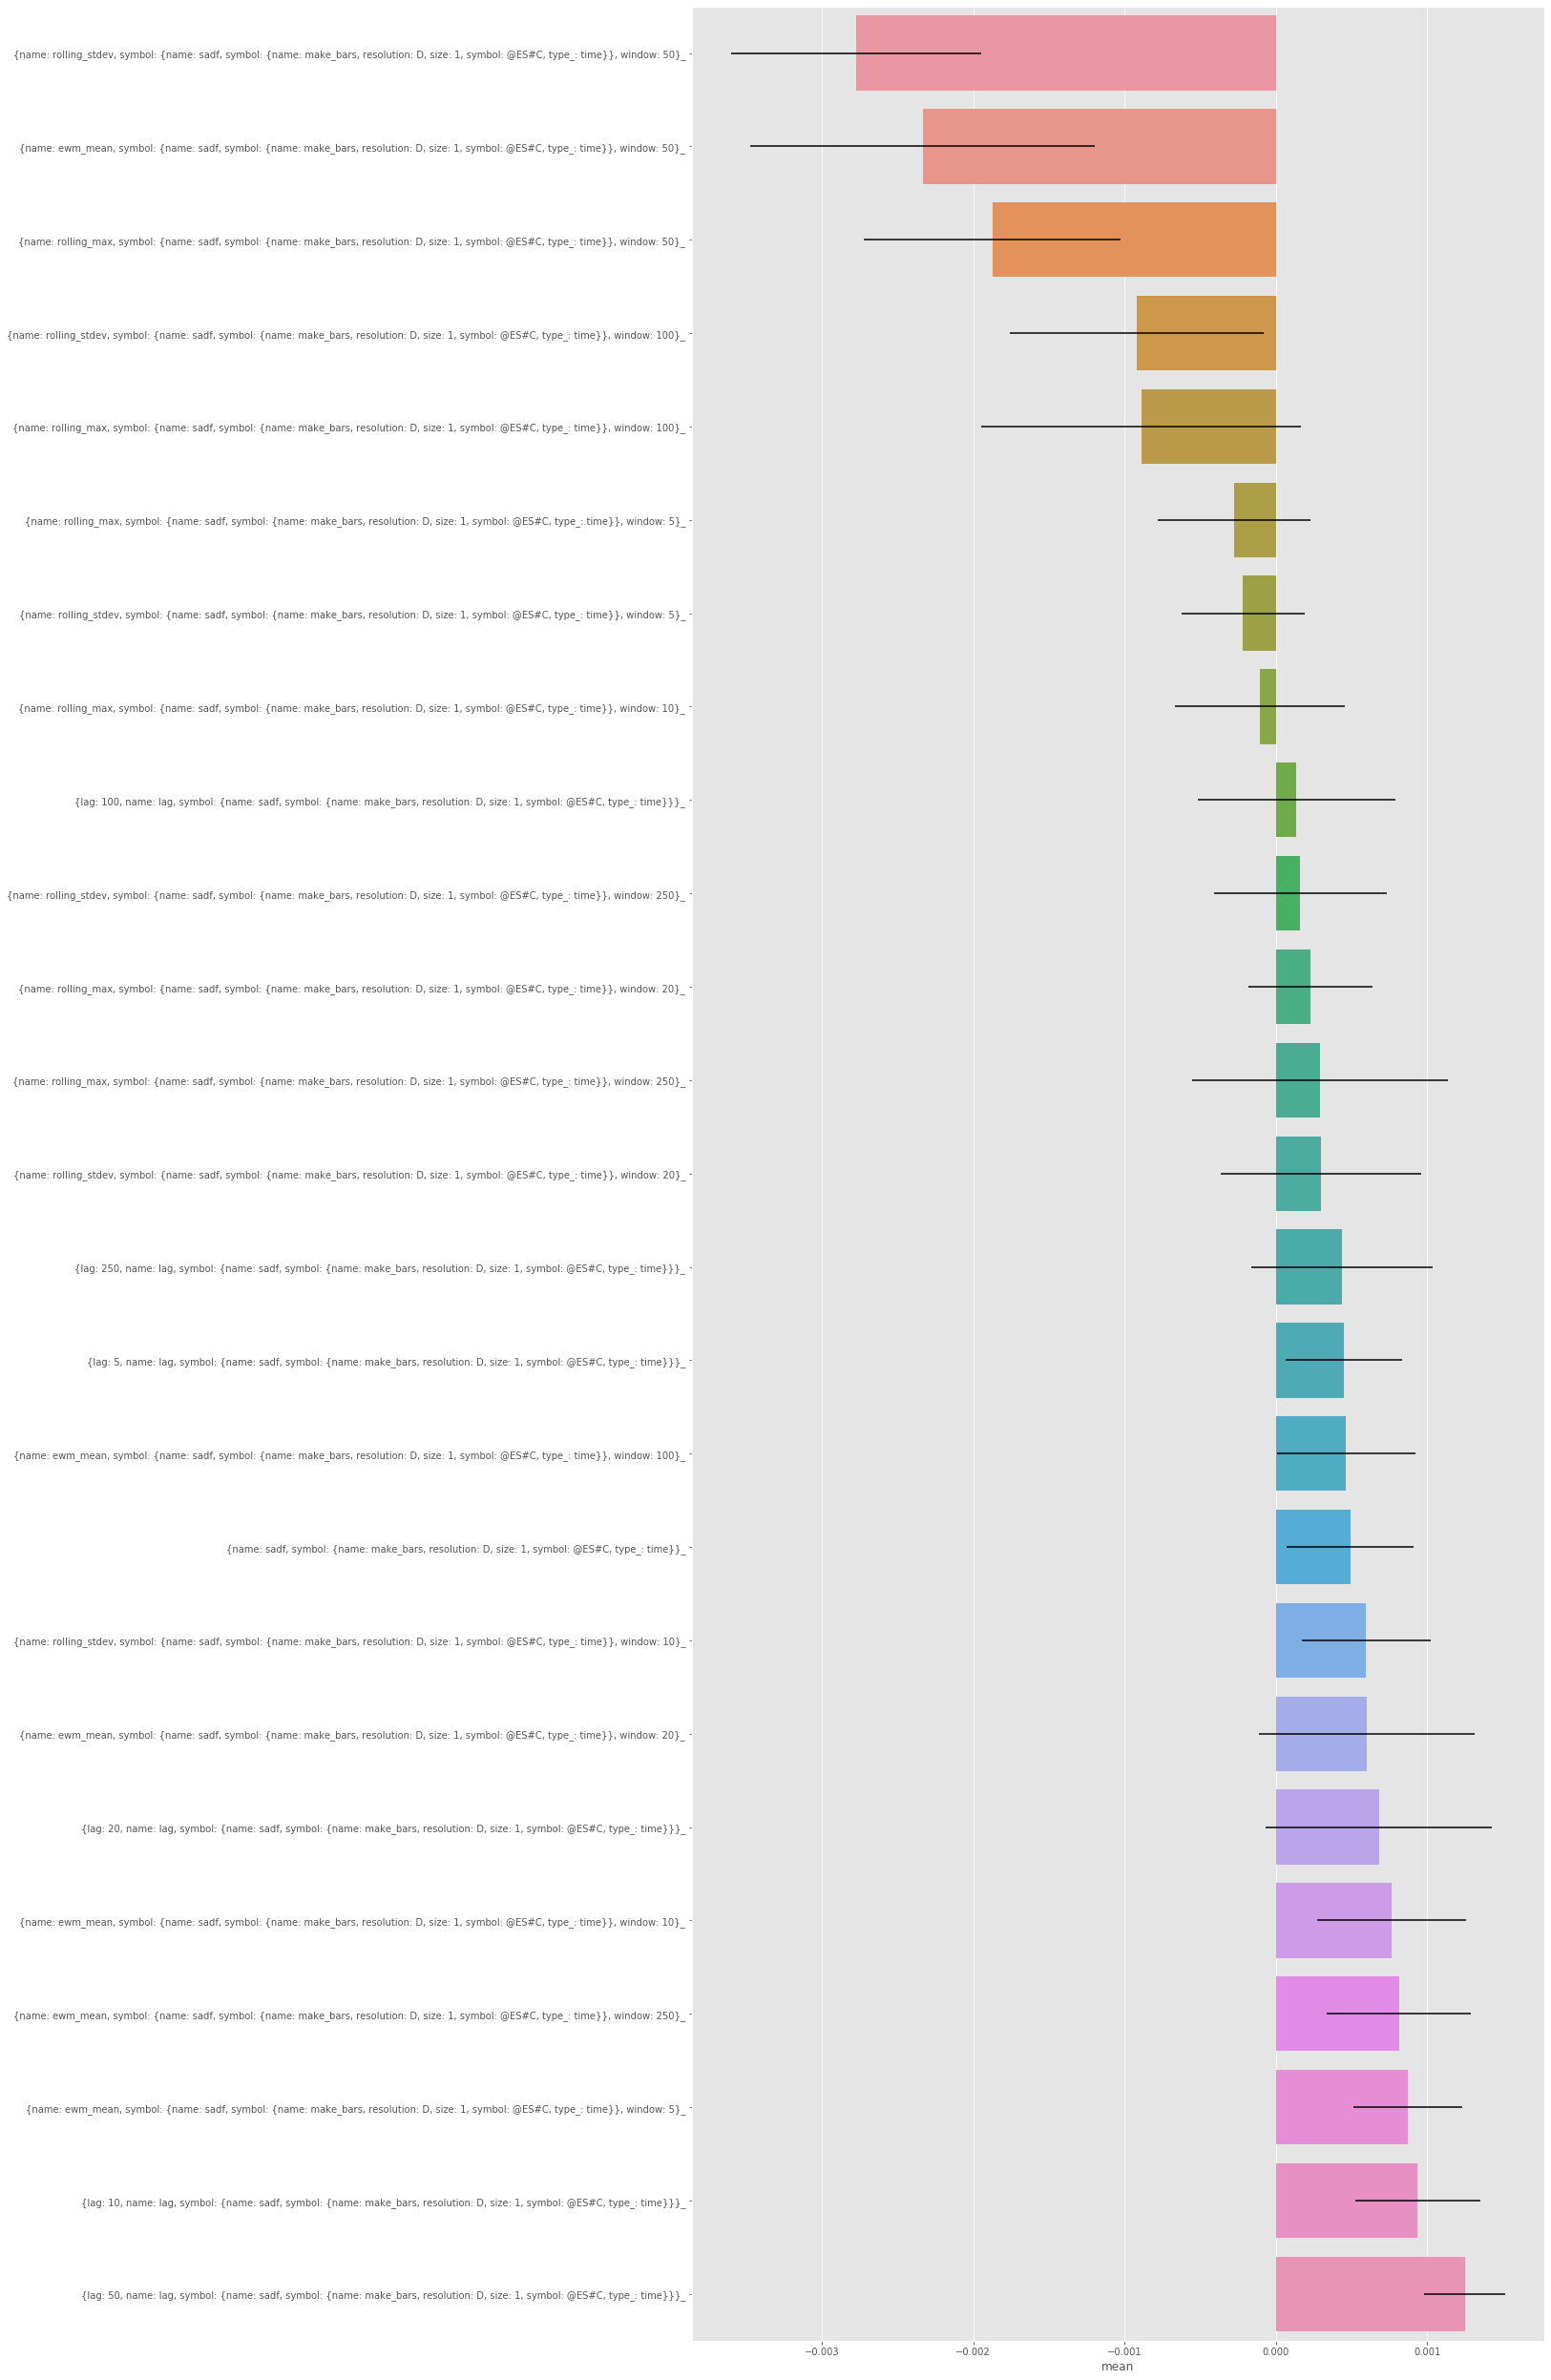

In [51]:
res3 = res
res3 = res3.sort_values('mean')
res3 = res3.loc[res3.index.str.contains('sadf')]
seaborn.barplot(y=[str(x).replace('\\','').replace('"', '') + '_' for x in res3.index.values], x=res3['mean'], xerr=res3['std'])

In [189]:
[x.basename().split('_')[0] for x in sorted((DATA_DIR / 'dollar').files("*events_100_fixed_horizon_50*"), key=lambda x:x.size)[::-1]]

['@SP#C',
 '@W#C',
 '@BO#C',
 '@QM#C',
 '@QG#C',
 'EZ#C',
 '@KC#C',
 '@C#C',
 'XG#C',
 '@S#C',
 'EX#C',
 '@SB#C',
 '@OJ#C',
 '@NKD#C',
 '@EMD#C',
 'BD#C',
 'LF#C',
 'QNG#C',
 'QCL#C',
 '@HE#C',
 '@CC#C',
 '@CT#C',
 '@LE#C',
 '@ES#C',
 '@TY#C',
 'QSI#C',
 'QPL#C',
 '@FV#C',
 '@O#C',
 'LG#C',
 '@SM#C',
 '@GF#C',
 'QGC#C',
 '@YM#C',
 '@TU#C',
 'QPA#C',
 '@UB#C',
 '@NQ#C',
 '@ED#C',
 'GAS#C',
 '@MME#C',
 'QHG#C',
 'QHO#C',
 '@BP#C',
 '@CD#C',
 '@RP#C',
 '@NE#C',
 '@AD#C']

In [190]:

ranked = [x for x in sorted((DATA_DIR / 'dollar').files("*bars*"), key=lambda x:x.size)[::-1]]

In [191]:
sp = pd.read_hdf(ranked[0], 'table')

In [192]:
sp.groupby(sp.index.year).count()

,Time,Open,High,Low,Close,Volume,Dollar Volume,Num Ticks,Buy Volume
Time,,,,,,,,,
2008,58383,58383,58383,58383,58383,58383,58383,58383,58383
2009,42514,42514,42514,42514,42514,42514,42514,42514,42514
2010,50946,50946,50946,50946,50946,50946,50946,50946,50946
2011,48232,48232,48232,48232,48232,48232,48232,48232,48232
2012,30992,30992,30992,30992,30992,30992,30992,30992,30992
2013,27647,27647,27647,27647,27647,27647,27647,27647,27647
2014,23178,23178,23178,23178,23178,23178,23178,23178,23178
2015,17997,17997,17997,17997,17997,17997,17997,17997,17997
2016,10588,10588,10588,10588,10588,10588,10588,10588,10588


In [193]:
for fn in ranked:
    print(fn)
    x = pd.read_hdf(fn, 'table')
    print(x.groupby(x.index.year).count())

C:\Users\doda/Dropbox/algotrading/data\dollar\@SP#C_bars.h5
       Time   Open   High    Low  Close  Volume  Dollar Volume  Num Ticks  \
Time                                                                        
2008  58383  58383  58383  58383  58383   58383          58383      58383   
2009  42514  42514  42514  42514  42514   42514          42514      42514   
2010  50946  50946  50946  50946  50946   50946          50946      50946   
2011  48232  48232  48232  48232  48232   48232          48232      48232   
2012  30992  30992  30992  30992  30992   30992          30992      30992   
2013  27647  27647  27647  27647  27647   27647          27647      27647   
2014  23178  23178  23178  23178  23178   23178          23178      23178   
2015  17997  17997  17997  17997  17997   17997          17997      17997   
2016  10588  10588  10588  10588  10588   10588          10588      10588   
2017   5031   5031   5031   5031   5031    5031           5031       5031   
2018   6935   69

       Time   Open   High    Low  Close  Volume  Dollar Volume  Num Ticks  \
Time                                                                        
2006    760    760    760    760    760     760            760        760   
2007   2034   2034   2034   2034   2034    2034           2034       2034   
2008   2481   2481   2481   2481   2481    2481           2481       2481   
2009   3720   3720   3720   3720   3720    3720           3720       3720   
2010   6863   6863   6863   6863   6863    6863           6863       6863   
2011   9647   9647   9647   9647   9647    9647           9647       9647   
2012  10681  10681  10681  10681  10681   10681          10681      10681   
2013   8225   8225   8225   8225   8225    8225           8225       8225   
2014   6923   6923   6923   6923   6923    6923           6923       6923   
2015   6152   6152   6152   6152   6152    6152           6152       6152   
2016   6893   6893   6893   6893   6893    6893           6893       6893   

      Time  Open  High   Low  Close  Volume  Dollar Volume  Num Ticks  \
Time                                                                    
2007  3961  3961  3961  3961   3961    3961           3961       3961   
2008  4717  4717  4717  4717   4717    4717           4717       4717   
2009  4108  4108  4108  4108   4108    4108           4108       4108   
2010  4563  4563  4563  4563   4563    4563           4563       4563   
2011  5244  5244  5244  5244   5244    5244           5244       5244   
2012  4645  4645  4645  4645   4645    4645           4645       4645   
2013  4743  4743  4743  4743   4743    4743           4743       4743   
2014  5467  5467  5467  5467   5467    5467           5467       5467   
2015  5934  5934  5934  5934   5934    5934           5934       5934   
2016  5930  5930  5930  5930   5930    5930           5930       5930   
2017  5520  5520  5520  5520   5520    5520           5520       5520   
2018  7002  7002  7002  7002   7002    7002        

      Time  Open  High   Low  Close  Volume  Dollar Volume  Num Ticks  \
Time                                                                    
2005   130   130   130   130    130     130            130        130   
2006   897   897   897   897    897     897            897        897   
2007  1066  1066  1066  1066   1066    1066           1066       1066   
2008  1288  1288  1288  1288   1288    1288           1288       1288   
2009  1398  1398  1398  1398   1398    1398           1398       1398   
2010  1832  1832  1832  1832   1832    1832           1832       1832   
2011  2527  2527  2527  2527   2527    2527           2527       2527   
2012  3414  3414  3414  3414   3414    3414           3414       3414   
2013  3859  3859  3859  3859   3859    3859           3859       3859   
2014  4037  4037  4037  4037   4037    4037           4037       4037   
2015  4627  4627  4627  4627   4627    4627           4627       4627   
2016  5367  5367  5367  5367   5367    5367        

AttributeError: 'Index' object has no attribute 'year'